# Thinkful Capstone: Exploring Hospital Fall Rates in 500 U.S. Cities.
### By Carley Fletcher

My Capstone project is to create an algorithm that can better predict and explain hospital patient fall rates. 

### Why Explain and Predict Hospital Falls?

   Hospitals have a major incentive to decrease falls due to the likely increase in patient care costs, length of stay, and liability. Furthermore, the Centers for Medicare and Medicaid Services (CMS) no longer pays for health care costs associated with falls during hospitalization, after deeming them events that should never occur during hospitalization [1].
   
   Helping hospitals focus their time and money on where they need to use to their resources is the primary goal of this project. A consulting healthcare company could market this model towards helping lower hospital acquired condition rates. Additionally, a public health agency might want this model to categorize and monitor how hospitals are performing.

## From Fall Data to Model

### Gathering and Scraping Data

   I compiled a list of hospitals with patient fall rates from two separate sources: Hospital-Data [2] and the Centers for Medicare & Medicaid Services [3]. Once I had these two datafiles, I then gathered data about these hospitals, cities, and states to use as features. One feature is indicating whether a hospital is an adult and/or pediatric trauma center [4]. Additional features include the rates of obesity, binge drinking, and stroke for cities in the US [5]. The last feature is the state level healthcare employee injury rates [6]. These are some of the features that I believe will help with my model’s explanation and prediction. 

The data cleaning and scraping that I performed for my capstone can be found here: https://github.com/BDSpecial/Thinkful-Assignments/blob/master/Capstone%20Data%20Cleaning.ipynb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
%matplotlib inline
import plotly.plotly as py
import plotly
import os
import IPython.display 

from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans

### Fall Data from Hospital-data.com

This is the fall data that I scraped from Hospital-data.com. I began by exploring the distribution of over 2,000 hospital and state falls rates. I can easily see that the large majority of hospital falls are less than 2 per 1,000 discharges with a mean of 0.71 and a max of 11.6. Additionally, this fall dataset has the majority of state fall rates around 0.7 per 1,000 discharges. When I graph the state average fall rates onto a map of the United States, I can see that the higher fall rates there appear to be in the mid-western states. 

In [2]:
fall_data = pd.read_csv('fall_data.csv')

In [3]:
print(fall_data.shape)
fall_data.head()

(2261, 5)


,hospital,hospital_falls,state_falls,state,city
0,Alaska Native Medical Center,1.312,1.414,AK,Anchorage
1,Yukon Kuskokwim Delta Reg Hospital,1.742,1.414,AK,Bethel
2,Fairbanks Memorial Hospital,0.790,1.414,AK,Fairbanks
3,Mt Edgecumbe Hospital,1.812,1.414,AK,Sitka
4,Shelby Baptist Medical Center,0.141,0.715,AL,Alabaster


In [4]:
fall_data.describe()

,hospital_falls,state_falls
count,2261.000000,2261.000000
mean,0.713582,0.715199
std,0.679179,0.166475
min,0.062000,0.479000
25%,0.367000,0.625000
50%,0.563000,0.681000
75%,0.840000,0.749000
max,11.628000,1.414000


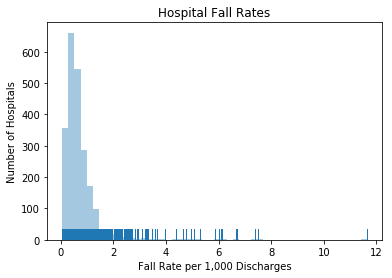

In [5]:
fig = sns.distplot(fall_data.hospital_falls, kde=False, rug=True)
plt.xlabel("Fall Rate per 1,000 Discharges")
plt.ylabel("Number of Hospitals")
plt.title('Hospital Fall Rates')
plt.show(fig)

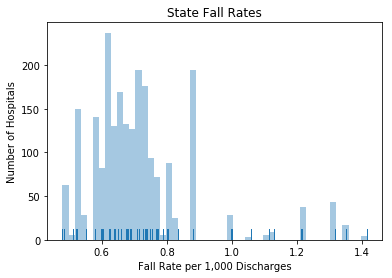

In [6]:
fig = sns.distplot(fall_data.state_falls, kde=False, rug=True)
plt.xlabel("Fall Rate per 1,000 Discharges")
plt.ylabel("Number of Hospitals")
plt.title('State Fall Rates')
plt.show(fig)

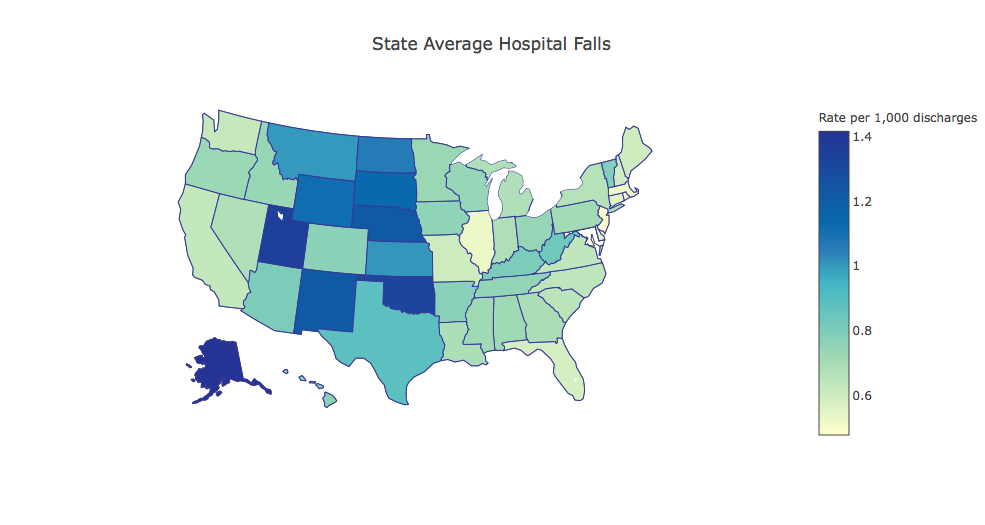

In [7]:
scraped_fall_image = IPython.display.Image(filename='scraped_falls.png')
scraped_fall_image

### Fall Data from the Centers for Medicare & Medicaid Services

This is a separate fall rate dataset that is from the Centers for Medicare & Medicaid Services. Initially, this dataset did not come with a state average fall rate for each state but I created this feature by averaging the hospital fall rates within each state. This dataset has over 3,000 hospitals. After exploring its layout, you can see that these hospital falls rates have a smaller distribution with the max of 7.8. The large majority of hospital fall rates are less than 1 per 1,000 discharges with a mean of 0.49. The state fall rates are also lower at 0.49 per 1,000 discharges. When I look at the state fall rate layout on the map of the United States, it appears to be more evenly distributed across the country.

In [8]:
CMS_Data = pd.read_csv('CMS_Data.csv')

In [9]:
print(CMS_Data.shape)
CMS_Data.head()

(3140, 5)


,hospital_fall_rate,state_average,hospital,city,state
0,0.812,0.437,Southeast Alabama Medical Center,Dothan,AL
1,0.445,0.437,Marshall Medical Center South,Boaz,AL
2,0.182,0.437,Eliza Coffee Memorial Hospital,Florence,AL
3,1.042,0.437,Mizell Memorial Hospital,Opp,AL
4,0.000,0.437,Crenshaw Community Hospital,Luverne,AL


In [10]:
CMS_Data.describe()

,hospital_fall_rate,state_average
count,3140.000000,3140.000000
mean,0.497063,0.497127
std,0.610596,0.093727
min,0.000000,0.295000
25%,0.000000,0.423000
50%,0.397000,0.513000
75%,0.660000,0.540000
max,7.874000,1.113000


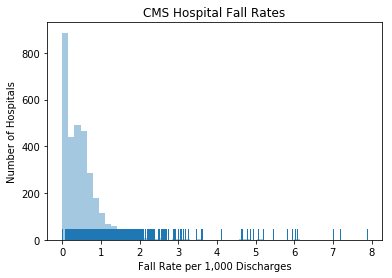

In [11]:
fig = sns.distplot(CMS_Data.hospital_fall_rate, kde=False, rug=True)
plt.xlabel("Fall Rate per 1,000 Discharges")
plt.ylabel("Number of Hospitals")
plt.title('CMS Hospital Fall Rates')
plt.show(fig)

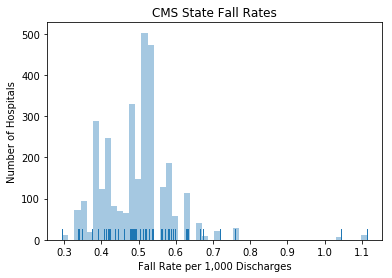

In [12]:
fig = sns.distplot(CMS_Data.state_average, kde=False, rug=True)
plt.xlabel("Fall Rate per 1,000 Discharges")
plt.ylabel("Number of Hospitals")
plt.title('CMS State Fall Rates')
plt.show(fig)

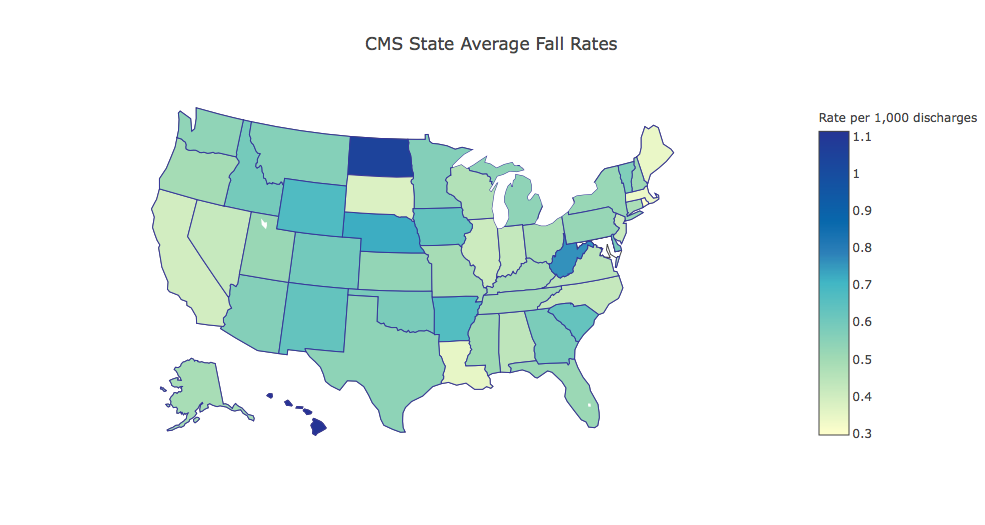

In [13]:
CMS_fall_image = IPython.display.Image(filename='CMS_falls.png')
CMS_fall_image

### Calculating Fall Meta-Analysis

Now, here is where I performed meta-analysis with these two fall datasets.

To briefly explain, meta-analysis is an approach to help combine studies or samples when trying to answer a specific question. A major reason for using meta-analysis is that no single sample or study is 100% definitive since there is the chance that our sample is not representative of what is being studied. 

Meta-analysis an approach, rather than a model, algorithm, or statistical technique. If the studies or samples being combined all use the same scale for measuring the outcome then basic averaging between the samples is an option. Otherwise, meta-analyses will convert study scores to what is called effect sizes. One of the simplest and most common is called Cohen’s d and is simply the difference in scores between two groups divided by the standard deviation: 

$d = \frac{Mean1-Mean2}{SD}$

For my capstone, both of my samples of hospital fall rates were measured on the same scale: rate per 1,000 discharges. Therefore, I decided to average the hospital and state fall rates for the same hospital from both datasets. 

In [14]:
complete_data = pd.read_csv('complete_data.csv')

In [15]:
print(complete_data.shape)
complete_data.head()

(2069, 5)


,hospital,state,city,meta_hospital_fall,meta_state_fall
0,Alaska Native Medical Center,AK,Anchorage,1.4280,0.9495
1,Yukon Kuskokwim Delta Reg Hospital,AK,Bethel,0.8710,0.9495
2,Fairbanks Memorial Hospital,AK,Fairbanks,0.7635,0.9495
3,Shelby Baptist Medical Center,AL,Alabaster,0.2765,0.5760
4,Russell Hospital,AL,Alexander City,0.4655,0.5760


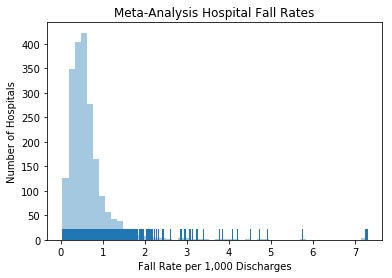

In [16]:
fig = sns.distplot(complete_data.meta_hospital_fall, kde=False, rug=True)
plt.xlabel("Fall Rate per 1,000 Discharges")
plt.ylabel("Number of Hospitals")
plt.title('Meta-Analysis Hospital Fall Rates')
plt.show(fig)

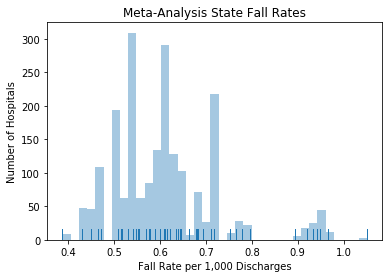

In [17]:
fig = sns.distplot(complete_data.meta_state_fall, kde=False, rug=True)
plt.xlabel("Fall Rate per 1,000 Discharges")
plt.ylabel("Number of Hospitals")
plt.title('Meta-Analysis State Fall Rates')
plt.show(fig)

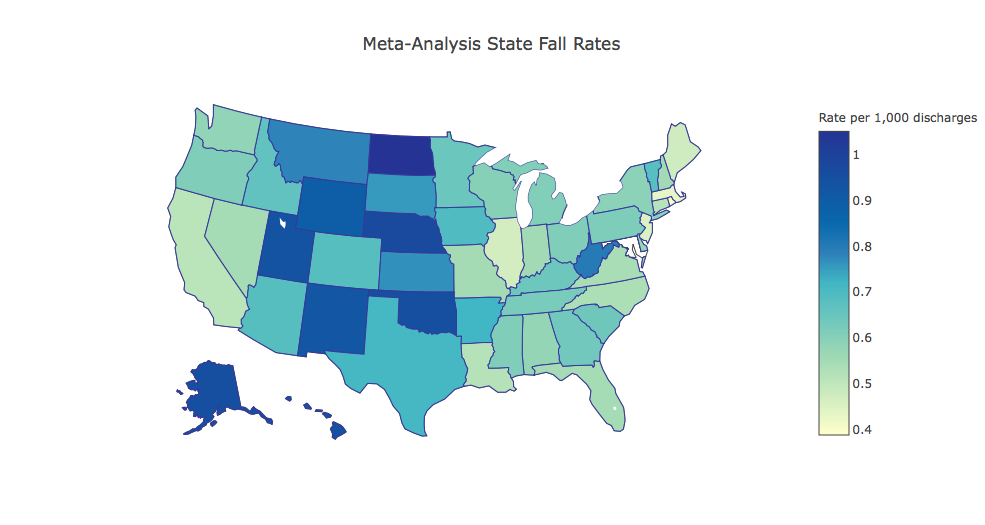

In [18]:
meta_state_fall_image = IPython.display.Image(filename='meta_state_fall.png')
meta_state_fall_image

## Exploring Features

### Hospital Feature

A trauma center is a hospital equipped and staffed to provide care for patients suffering from major traumatic injuries such as falls, motor vehicle collisions, or gunshot wounds. Trauma centers are separated into adult and pediatric and are then ranked from level 1 being the highest and level 3 the lowest. Here I am looking at the number of trauma centers throughout the United States.

In [19]:
state_trauma = pd.read_csv('state_trauma.csv')

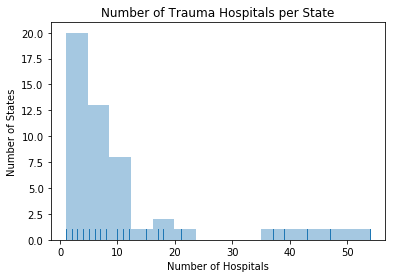

In [20]:
fig = sns.distplot(state_trauma.trauma_hospital_number, kde=False, rug=True)
plt.xlabel("Number of Hospitals")
plt.ylabel("Number of States")
plt.title('Number of Trauma Hospitals per State')
plt.show(fig)

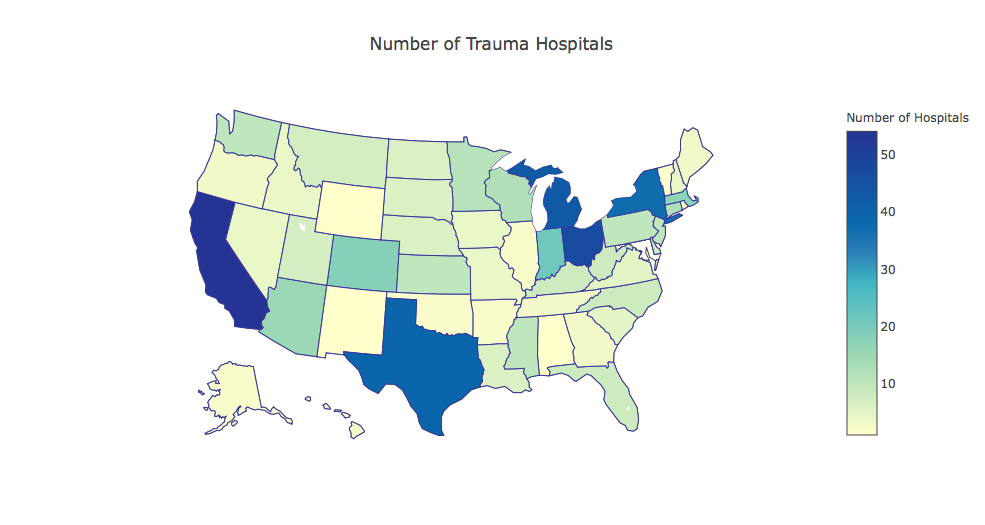

In [21]:
trauma_hospital_image = IPython.display.Image(filename='Trauma_hospitals.png')
trauma_hospital_image

### State Feature

Here I have the rate of employee injury in the healthcare industry. I collected this data from the Bureau of Labor Statistics State Occupational Injuries, Illnesses, and Fatalities.

In [22]:
complete_worker_injury = pd.read_csv('complete_worker_injury.csv')

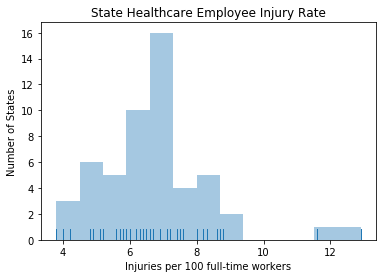

In [23]:
fig = sns.distplot(complete_worker_injury.total_recordable_cases, kde=False, rug=True)
plt.xlabel("Injuries per 100 full-time workers")
plt.ylabel("Number of States")
plt.title('State Healthcare Employee Injury Rate')
plt.show(fig)

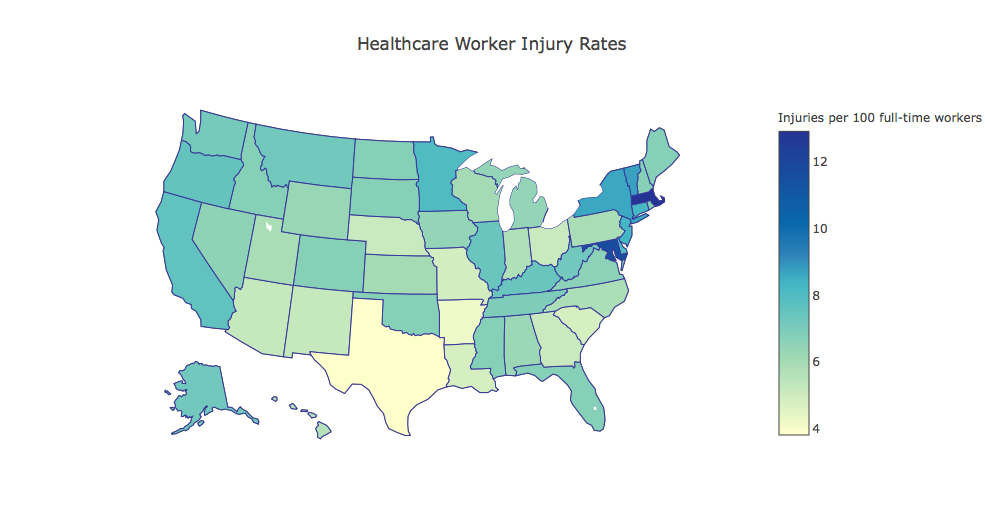

In [24]:
worker_injury_image = IPython.display.Image(filename='worker_injury.png')
worker_injury_image

### City Feature

My city features came from the Center of Disease Control's 500 Cities Project. This project provides small area estimates for chronic disease risk factors, health outcomes, and clinical preventive service use for the largest 500 cities in the United States. 

In [25]:
city_locations = IPython.display.Image(url='https://www.cdc.gov/500cities/images/500-cities-map-734w.png')
city_locations

In [26]:
state_averages = pd.read_csv('state_averages.csv')

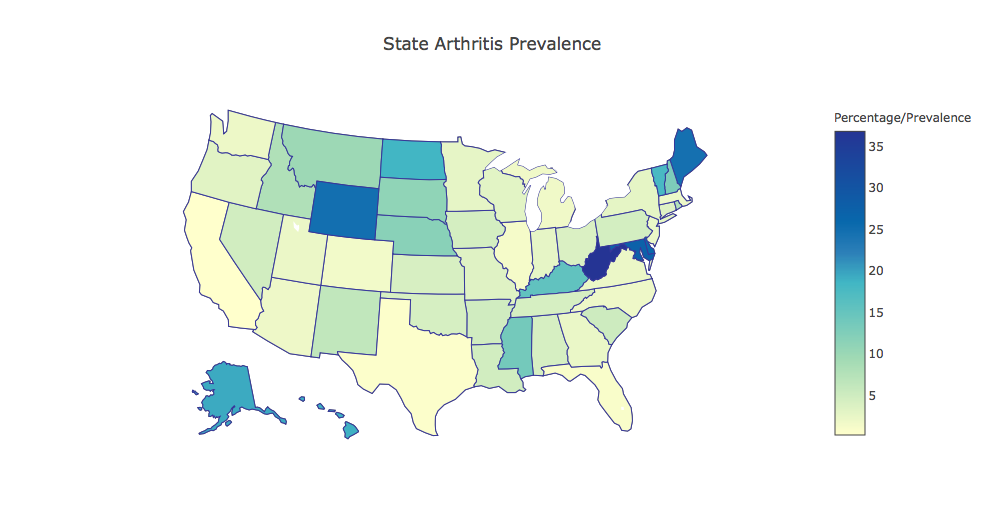

In [27]:
state_arthritis_image = IPython.display.Image(filename='state_arthritis.png')
state_arthritis_image

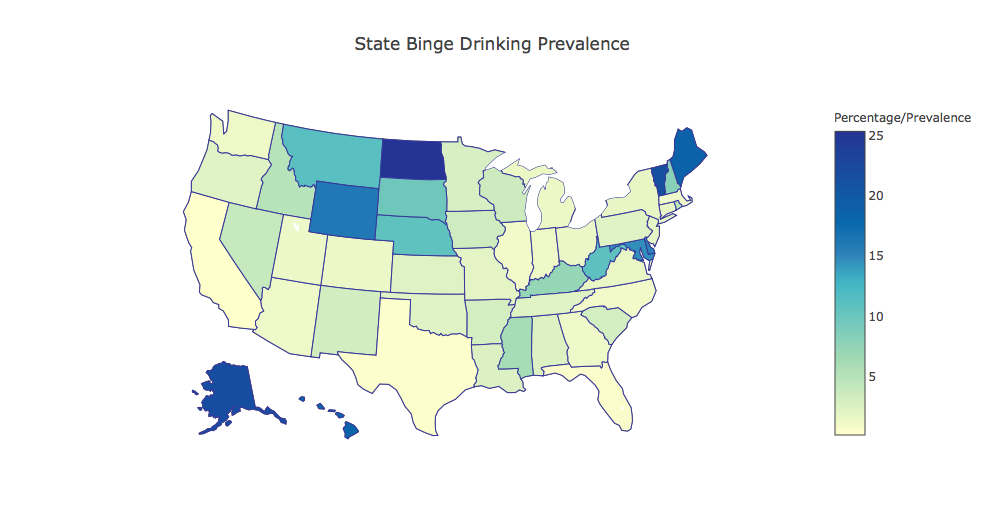

In [28]:
state_binge_image = IPython.display.Image(filename='state_binge.png')
state_binge_image

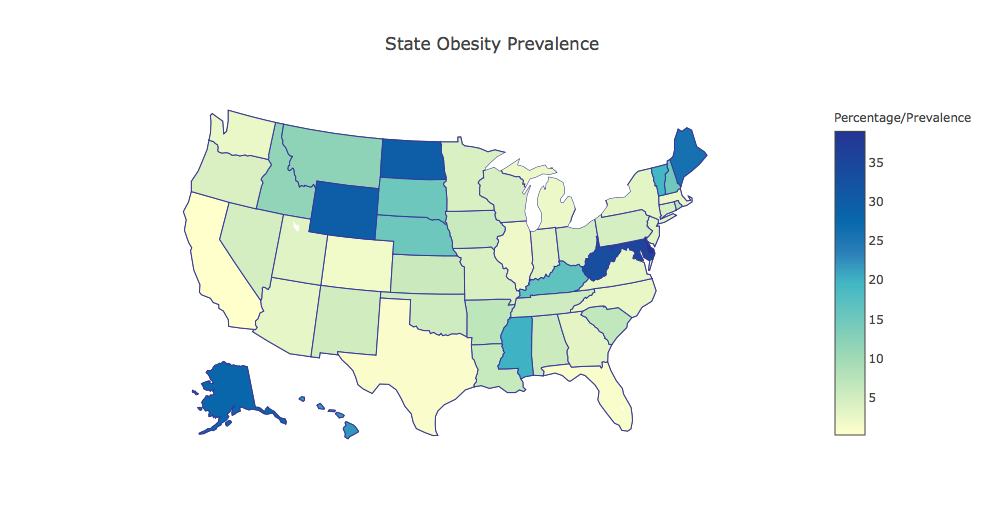

In [29]:
state_obesity_image = IPython.display.Image(filename='state_obesity.png')
state_obesity_image

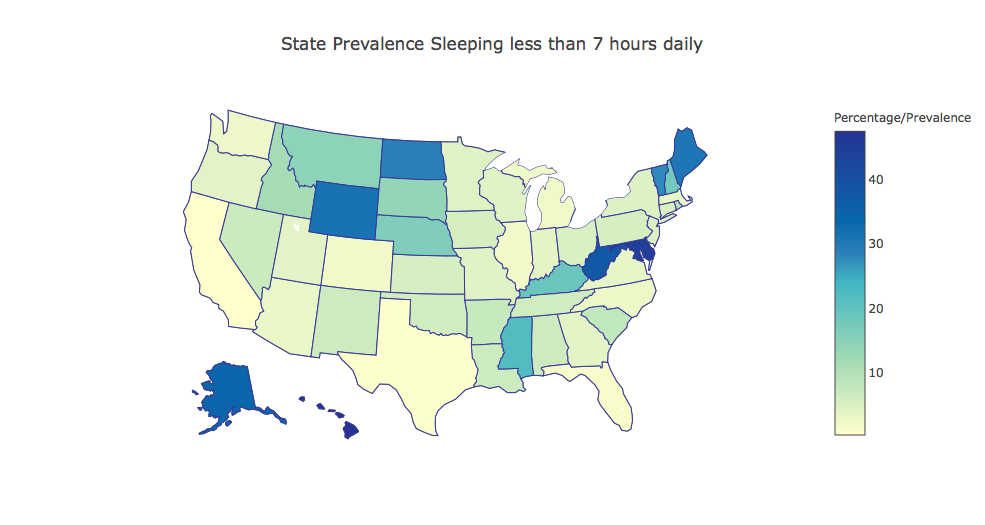

In [30]:
state_sleep_image = IPython.display.Image(filename='state_sleep.png')
state_sleep_image

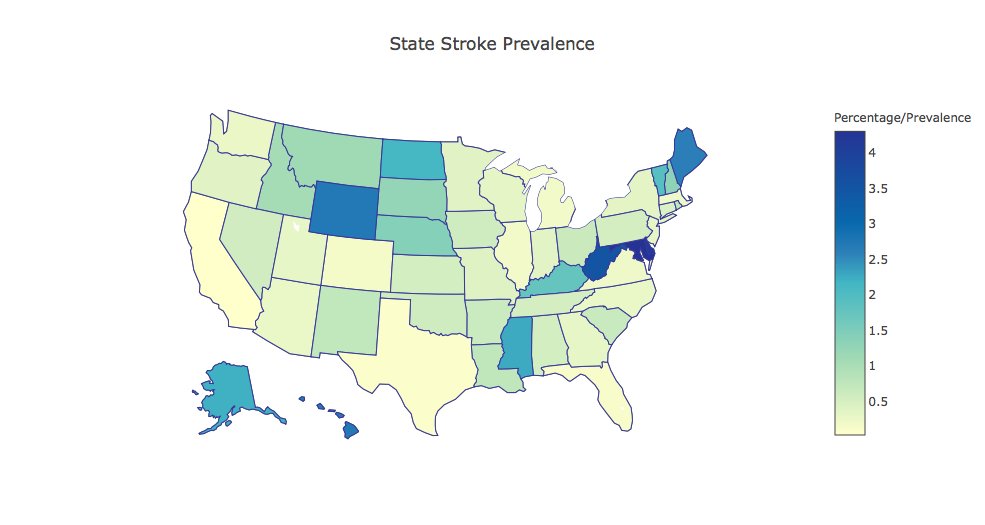

In [31]:
state_stroke_image = IPython.display.Image(filename='state_stroke.png')
state_stroke_image

## Merging Data into one Dataset

My last step before modeling is to join my meta-analysis fall dataset with each of the hospital, state, and city features that I gathered above. The dataset will remain the same size until I only select hospitals that are in one of the 500 cities from the CDC's 500 cities project. 

In [32]:
print(complete_data.shape)
complete_data.head()

(2069, 5)


,hospital,state,city,meta_hospital_fall,meta_state_fall
0,Alaska Native Medical Center,AK,Anchorage,1.4280,0.9495
1,Yukon Kuskokwim Delta Reg Hospital,AK,Bethel,0.8710,0.9495
2,Fairbanks Memorial Hospital,AK,Fairbanks,0.7635,0.9495
3,Shelby Baptist Medical Center,AL,Alabaster,0.2765,0.5760
4,Russell Hospital,AL,Alexander City,0.4655,0.5760


In [33]:
complete_trauma = pd.read_csv('complete_trauma.csv')

In [34]:
print(complete_trauma.shape)
complete_trauma.head()

(2069, 7)


,hospital,state,city,meta_hospital_fall,meta_state_fall,adult_trauma,pediatric_trauma
0,Alaska Native Medical Center,AK,Anchorage,1.4280,0.9495,1,0
1,Yukon Kuskokwim Delta Reg Hospital,AK,Bethel,0.8710,0.9495,0,0
2,Fairbanks Memorial Hospital,AK,Fairbanks,0.7635,0.9495,0,0
3,Shelby Baptist Medical Center,AL,Alabaster,0.2765,0.5760,0,0
4,Russell Hospital,AL,Alexander City,0.4655,0.5760,0,0


In [35]:
complete_injury = pd.read_csv('complete_injury.csv')

In [36]:
print(complete_injury.shape)
complete_injury.head()

(2069, 8)


,hospital,state,city,meta_hospital_fall,meta_state_fall,adult_trauma,pediatric_trauma,total_recordable_cases
0,Alaska Native Medical Center,AK,Anchorage,1.4280,0.9495,1,0,7.2
1,Yukon Kuskokwim Delta Reg Hospital,AK,Bethel,0.8710,0.9495,0,0,7.2
2,Fairbanks Memorial Hospital,AK,Fairbanks,0.7635,0.9495,0,0,7.2
3,Shelby Baptist Medical Center,AL,Alabaster,0.2765,0.5760,0,0,6.2
4,Russell Hospital,AL,Alexander City,0.4655,0.5760,0,0,6.2


In [37]:
city_data = pd.read_csv('city_data.csv')

In [38]:
print(city_data.shape)
city_data.head()

(500, 8)


,StateAbbr,PlaceName,Population2010,ARTHRITIS_CrudePrev,BINGE_CrudePrev,OBESITY_CrudePrev,SLEEP_CrudePrev,STROKE_CrudePrev
0,AL,Birmingham,212237,32.6,11.5,38.2,46.5,5.0
1,AL,Hoover,81619,26.3,15.4,25.0,34.6,2.3
2,AL,Huntsville,180105,30.0,12.2,31.4,39.2,3.3
3,AL,Mobile,195111,33.1,12.5,37.0,41.6,4.3
4,AL,Montgomery,205764,31.0,12.5,36.3,41.1,4.0


In [39]:
complete_fall_data = pd.read_csv('complete_fall_data.csv')

In [40]:
print(complete_fall_data.shape)
complete_fall_data.head()

(796, 14)


,hospital,state,city,meta_hospital_fall,meta_state_fall,adult_trauma,pediatric_trauma,total_recordable_cases,Population2010,ARTHRITIS_CrudePrev,BINGE_CrudePrev,OBESITY_CrudePrev,SLEEP_CrudePrev,STROKE_CrudePrev
0,Alaska Native Medical Center,AK,Anchorage,1.428,0.9495,1,0,7.2,291826,19.3,21.6,27.8,34.0,2.2
1,University Of Alabama Hospital,AL,Birmingham,0.359,0.5760,1,0,6.2,212237,32.6,11.5,38.2,46.5,5.0
2,Princeton Baptist Medical Center,AL,Birmingham,0.524,0.5760,0,0,6.2,212237,32.6,11.5,38.2,46.5,5.0
3,Brookwood Baptist Medical Center,AL,Birmingham,0.366,0.5760,0,0,6.2,212237,32.6,11.5,38.2,46.5,5.0
4,St Marys Hospital,IL,Decatur,0.959,0.4655,0,0,7.4,76122,29.9,17.1,34.4,35.5,4.0


# Explanatory Model

Now that I have my final dataset I will move onto modeling with my dataset. My initial goal is to create an explanatory model that will help hospital understand what features are contributing to their fall rates. Let me first explore the correlation between features and my dependent outcome, meta_hospital_fall.

In [41]:
complete_fall_data.describe()

,meta_hospital_fall,meta_state_fall,adult_trauma,pediatric_trauma,total_recordable_cases,Population2010,ARTHRITIS_CrudePrev,BINGE_CrudePrev,OBESITY_CrudePrev,SLEEP_CrudePrev,STROKE_CrudePrev
count,796.000000,796.000000,796.000000,796.000000,796.000000,7.960000e+02,796.000000,796.000000,796.000000,796.000000,796.000000
mean,0.591928,0.611136,0.326633,0.017588,6.349497,5.518945e+05,22.685427,16.641080,30.005528,36.280025,3.023744
std,0.609685,0.123058,0.469277,0.131531,1.656734,1.027549e+06,4.180453,2.529267,5.330847,4.348801,0.711806
min,0.038500,0.387000,0.000000,0.000000,3.800000,4.241700e+04,9.400000,9.100000,16.100000,24.400000,1.300000
25%,0.317625,0.508500,0.000000,0.000000,5.100000,1.085000e+05,19.500000,15.100000,26.100000,33.675000,2.575000
50%,0.482500,0.589500,0.000000,0.000000,6.600000,2.089160e+05,22.400000,16.400000,30.600000,36.100000,3.000000
75%,0.648750,0.693000,1.000000,0.000000,7.500000,5.837560e+05,25.400000,18.200000,33.400000,38.600000,3.400000
max,7.249500,1.050500,1.000000,1.000000,12.900000,8.175133e+06,36.800000,25.300000,47.100000,51.300000,6.500000


In [42]:
complete_fall_data.corr()

,meta_hospital_fall,meta_state_fall,adult_trauma,pediatric_trauma,total_recordable_cases,Population2010,ARTHRITIS_CrudePrev,BINGE_CrudePrev,OBESITY_CrudePrev,SLEEP_CrudePrev,STROKE_CrudePrev
meta_hospital_fall,1.000000,0.229021,-0.069776,-0.057691,-0.133069,-0.067370,-0.003566,-0.029333,0.029045,-0.076335,-0.019783
meta_state_fall,0.229021,1.000000,0.027828,-0.019810,-0.496166,-0.051973,-0.034724,-0.122910,0.117830,-0.209603,-0.086935
adult_trauma,-0.069776,0.027828,1.000000,-0.093189,0.018494,0.033301,-0.017832,0.040397,0.035631,-0.043026,-0.009314
pediatric_trauma,-0.057691,-0.019810,-0.093189,1.000000,0.035252,0.092122,-0.055580,0.035636,-0.053957,-0.011260,-0.036710
total_recordable_cases,-0.133069,-0.496166,0.018494,0.035252,1.000000,0.088824,0.046159,0.077132,-0.287252,0.119122,-0.062778
Population2010,-0.067370,-0.051973,0.033301,0.092122,0.088824,1.000000,-0.162872,0.021018,-0.075839,0.157546,-0.000267
ARTHRITIS_CrudePrev,-0.003566,-0.034724,-0.017832,-0.055580,0.046159,-0.162872,1.000000,-0.386655,0.609555,0.483021,0.790281
BINGE_CrudePrev,-0.029333,-0.122910,0.040397,0.035636,0.077132,0.021018,-0.386655,1.000000,-0.383592,-0.441416,-0.483873
OBESITY_CrudePrev,0.029045,0.117830,0.035631,-0.053957,-0.287252,-0.075839,0.609555,-0.383592,1.000000,0.618345,0.775408
SLEEP_CrudePrev,-0.076335,-0.209603,-0.043026,-0.011260,0.119122,0.157546,0.483021,-0.441416,0.618345,1.000000,0.711483


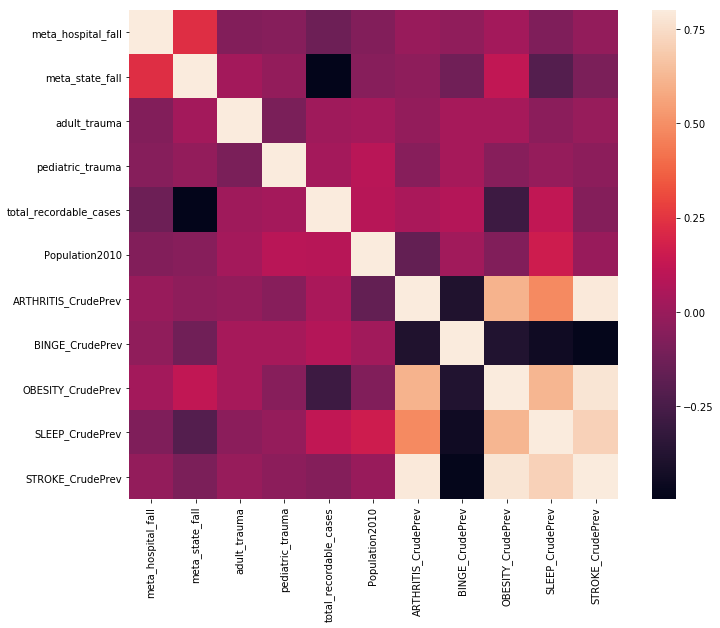

In [43]:
# Make the correlation matrix.
corrmat = complete_fall_data.corr()

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

In [44]:
#Next I isolate only the continuous variables so that I can visualize any correlation. 
continuous = complete_fall_data.loc[:, ['meta_hospital_fall', 'meta_state_fall', 'adult_trauma', 'pediatric_trauma', 
                                   'total_recordable_cases', 'Population2010', 'ARTHRITIS_CrudePrev', 'BINGE_CrudePrev',
                                   'OBESITY_CrudePrev', 'SLEEP_CrudePrev', 'STROKE_CrudePrev']]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


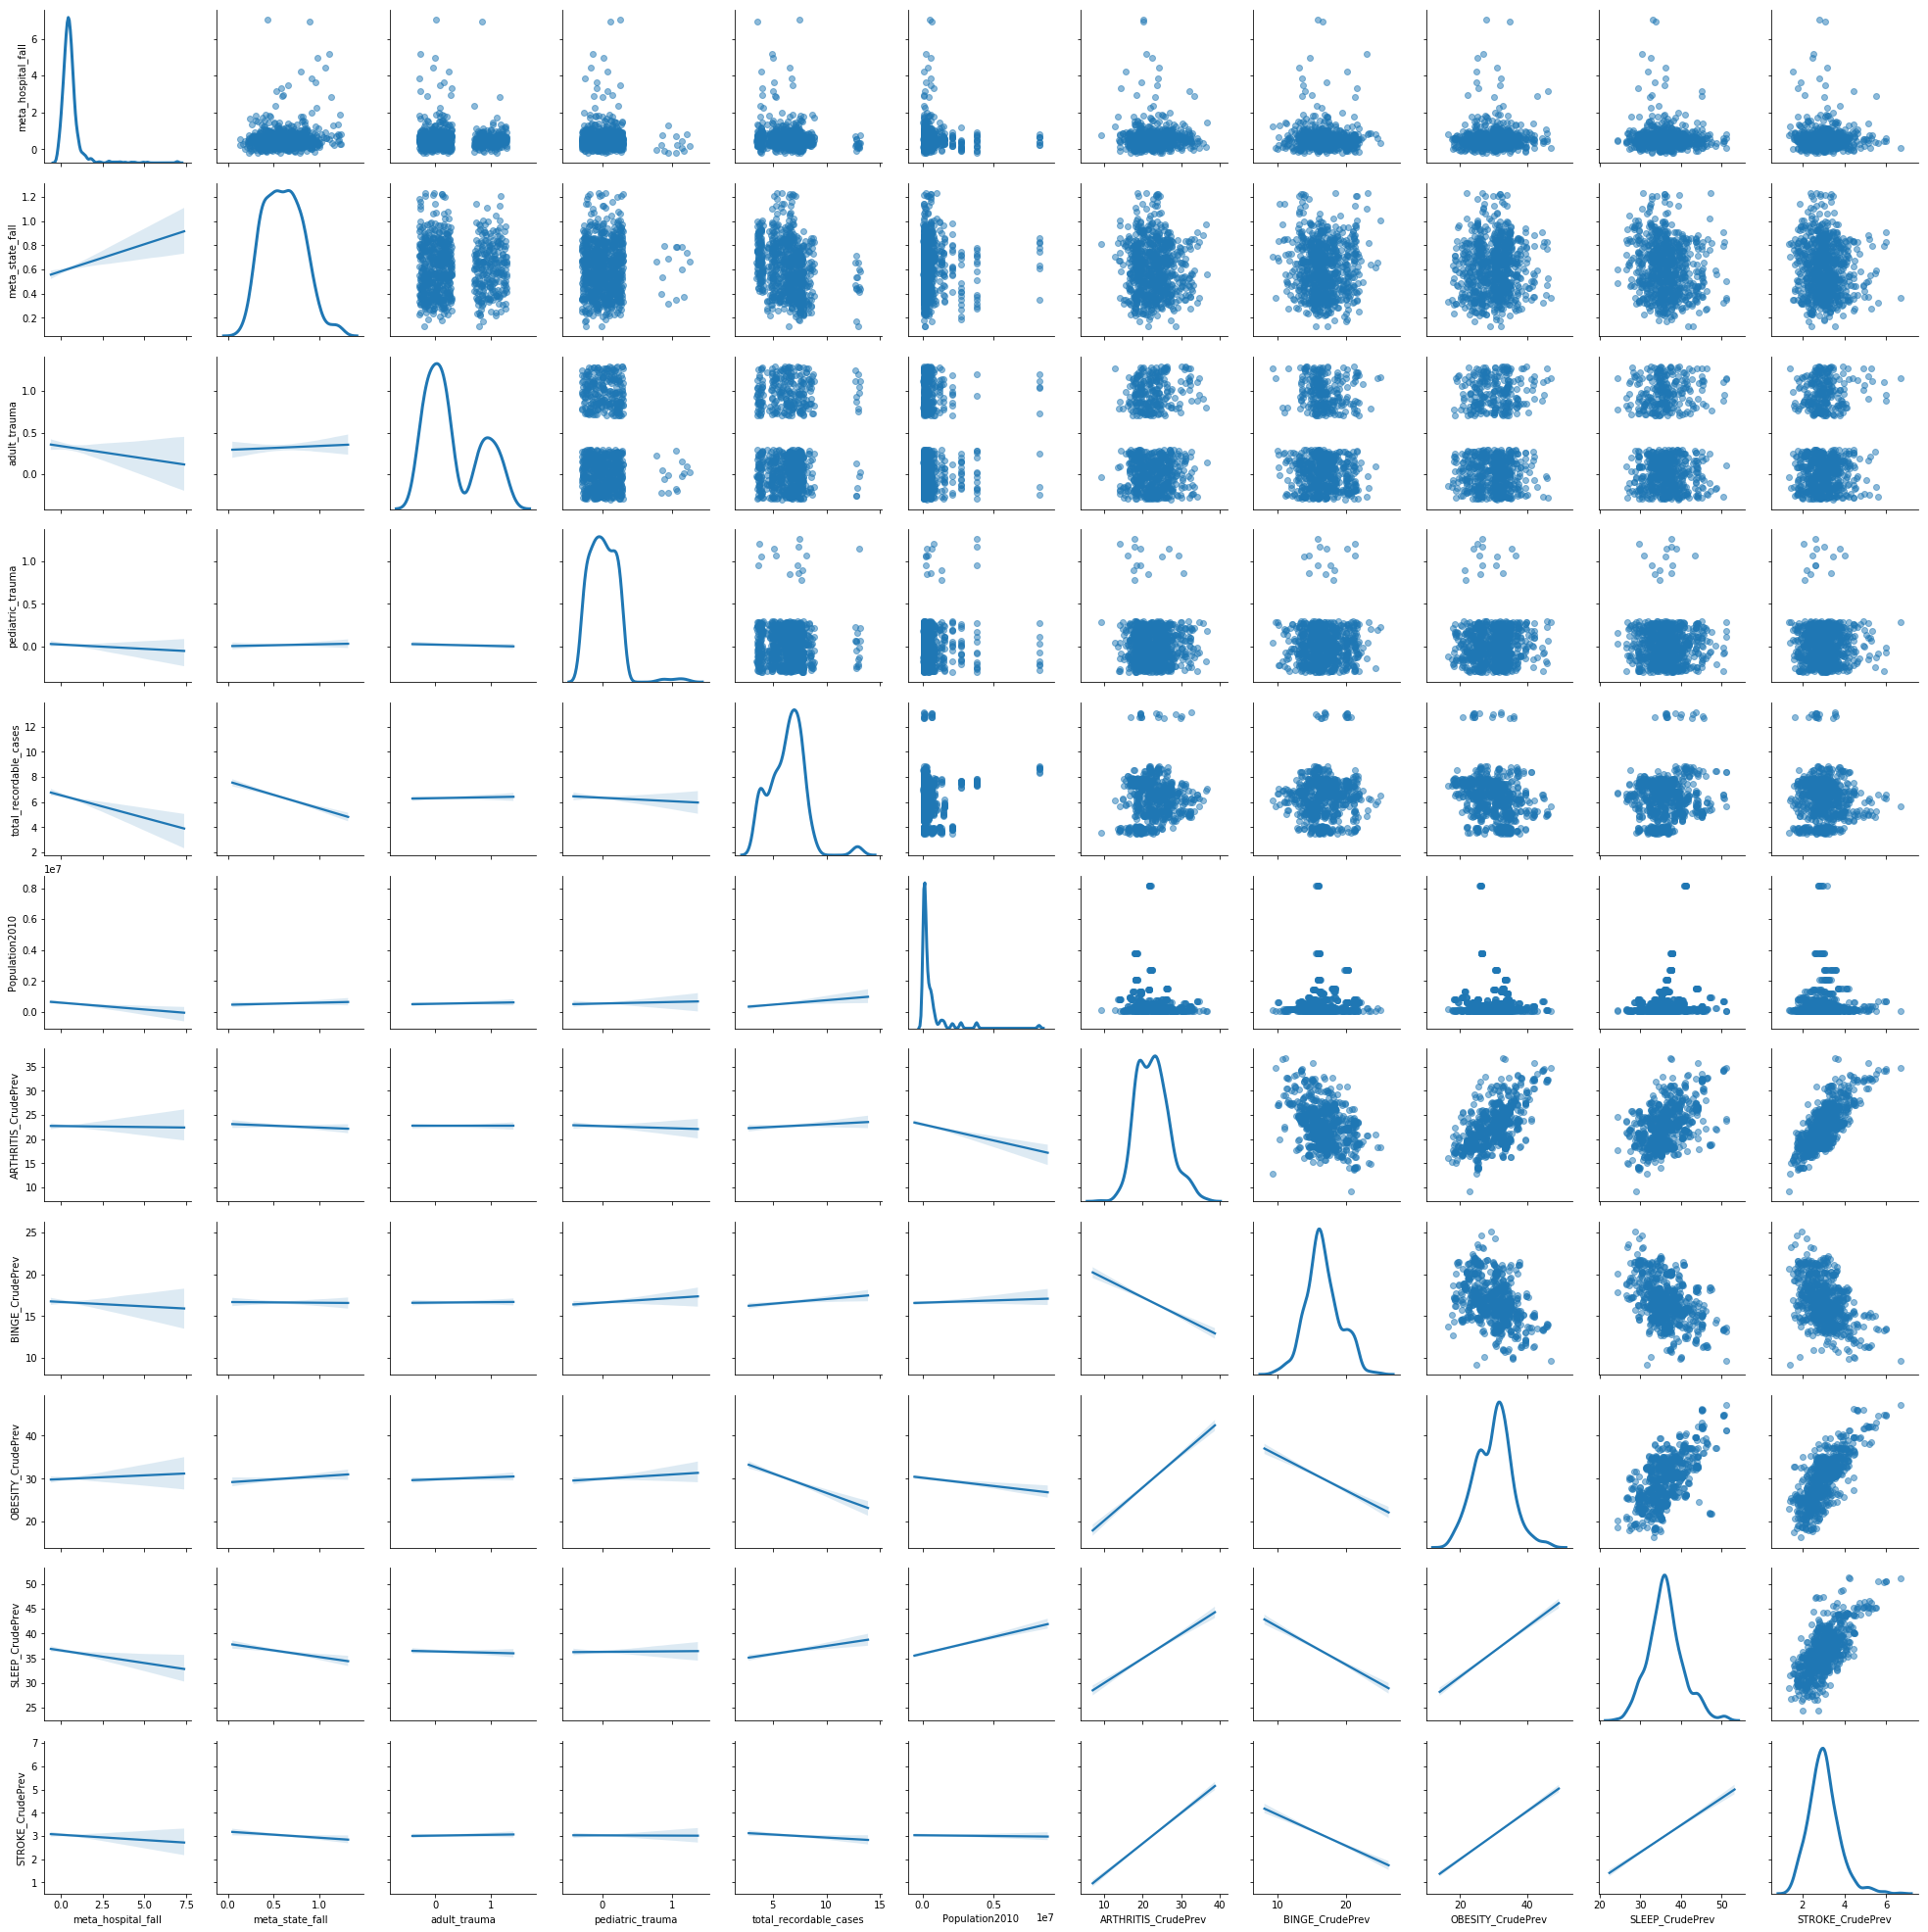

In [45]:
# Making the random noise.
jitter = pd.DataFrame(
    np.random.uniform(-.3, .3, size=(continuous.shape)),
    columns=continuous.columns
)
# Combine the data and the noise.
continuous = continuous.add(jitter)

# Declare that you want to make a scatterplot matrix.
g = sns.PairGrid(continuous.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

## Regression Models

My initial goal is to create an explanatory model, so regression models will be very useful for explaining the relationship between the features and hospital fall rates. I will use both random forest regression and linear regression models. 

In [46]:
#Define the features and the outcome.
X = complete_fall_data.drop(['hospital', 'meta_hospital_fall', 'city'], axis=1)
y = complete_fall_data.meta_hospital_fall

#In order to have the states as a feature I need use get_dummies
X = pd.get_dummies(X)

In [47]:
# Random Forest Regression
rfr = ensemble.RandomForestRegressor(n_estimators=50, max_depth=5)
rfr.fit(X, y)
print(rfr)
print('Training set score:', rfr.score(X, y))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Training set score: 0.25217969805076557


In [48]:
RFR_score = cross_val_score(rfr, X, y, cv=5)
print('\nEach Cross Validated R2 score: \n', RFR_score)
print("\nOverall Random Forest Regression R2: %0.2f (+/- %0.2f)\n" % (RFR_score.mean(), RFR_score.std() * 2))


Each Cross Validated R2 score: 
 [-0.00782244 -0.33508102 -1.01297976 -0.02362532  0.00242513]

Overall Random Forest Regression R2: -0.28 (+/- 0.78)



In [49]:
# Saving the feature names
feature_list = list(X.columns)
# Get numerical feature importances
importances = list(rfr.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

In [50]:
feature_importances = feature_importances[:20]

In [51]:
feature_importances

[('meta_state_fall', 0.16),
 ('Population2010', 0.14),
 ('STROKE_CrudePrev', 0.14),
 ('SLEEP_CrudePrev', 0.11),
 ('BINGE_CrudePrev', 0.1),
 ('OBESITY_CrudePrev', 0.09),
 ('adult_trauma', 0.08),
 ('ARTHRITIS_CrudePrev', 0.06),
 ('state_NM', 0.03),
 ('total_recordable_cases', 0.02),
 ('pediatric_trauma', 0.01),
 ('state_AZ', 0.01),
 ('state_CA', 0.01),
 ('state_NE', 0.01),
 ('state_OH', 0.01),
 ('state_OK', 0.01),
 ('state_AK', 0.0),
 ('state_AL', 0.0),
 ('state_AR', 0.0),
 ('state_CO', 0.0)]

In [52]:
# Logistic Regression
lr = LinearRegression(n_jobs=20)
lr.fit(X, y)
print(lr)
print('Training set score:', lr.score(X, y))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=20, normalize=False)
Training set score: 0.10898307850282053


/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning:

internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.



In [53]:
LR_score = cross_val_score(lr, X, y, cv=5)
print('\nEach Cross Validated R2 score: \n', LR_score)
print("\nOverall Linear Regression R2: %0.2f (+/- %0.2f)\n" % (LR_score.mean(), LR_score.std() * 2))


Each Cross Validated R2 score: 
 [-0.00222326 -0.23515336 -0.19107563  0.01601725 -0.03245238]

Overall Linear Regression R2: -0.09 (+/- 0.21)



## Classification Models

Since neither of my regression models perform well, I am going separate the hospitals into high and low fall rates and then use a classification model. I will change my outcome to a binary feature for high and low fall rates. I will set the threshold at 0.6 because the mean for hospital falls is 0.59 with the 50th percentile at 0.48. 

In [54]:
complete_fall_data.meta_hospital_fall.describe()

count    796.000000
mean       0.591928
std        0.609685
min        0.038500
25%        0.317625
50%        0.482500
75%        0.648750
max        7.249500
Name: meta_hospital_fall, dtype: float64

In [55]:
complete_fall_data['high_low'] = 0
for i in range(len(complete_fall_data)):
    if complete_fall_data.meta_hospital_fall[i] >= 0.6:
        complete_fall_data.loc[i, 'high_low'] = 1

In [56]:
#Define the features and the outcome.
X = complete_fall_data.drop(['hospital', 'meta_hospital_fall', 'high_low', 'city'], axis=1)
y = complete_fall_data.high_low

#In order to have the states as a feature I need use get_dummies
X = pd.get_dummies(X)

In [57]:
# Random Forest Classification
rfc = ensemble.RandomForestClassifier(n_estimators=70, max_depth=10)
rfc.fit(X, y)
print(rfc)
print('Training set score:', rfc.score(X, y))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Training set score: 0.7989949748743719


In [58]:
RFC_score = cross_val_score(rfc, X, y, cv=5)
print('\nEach Cross Validated Accuracy: \n', RFC_score)
print("\nOverall Random Forest Classification Accuracy: %0.2f (+/- %0.2f)\n" % (RFC_score.mean(), RFC_score.std() * 2))


Each Cross Validated Accuracy: 
 [0.675      0.60625    0.43125    0.5        0.47468354]

Overall Random Forest Classification Accuracy: 0.54 (+/- 0.18)



In [59]:
print("Report:")
y_true, y_pred = y, rfc.predict(X)
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

Report:
             precision    recall  f1-score   support

          0       0.78      0.98      0.87       543
          1       0.90      0.42      0.57       253

avg / total       0.82      0.80      0.77       796



array([[531,  12],
       [148, 105]])

In [60]:
# Saving the feature names
feature_list = list(X.columns)
# Get numerical feature importances
importances = list(rfc.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

In [61]:
feature_importances = feature_importances[:20]

In [62]:
feature_importances

[('Population2010', 0.13),
 ('ARTHRITIS_CrudePrev', 0.11),
 ('OBESITY_CrudePrev', 0.11),
 ('SLEEP_CrudePrev', 0.11),
 ('BINGE_CrudePrev', 0.1),
 ('meta_state_fall', 0.08),
 ('STROKE_CrudePrev', 0.08),
 ('adult_trauma', 0.06),
 ('total_recordable_cases', 0.05),
 ('pediatric_trauma', 0.01),
 ('state_FL', 0.01),
 ('state_IN', 0.01),
 ('state_MI', 0.01),
 ('state_NE', 0.01),
 ('state_OK', 0.01),
 ('state_TN', 0.01),
 ('state_TX', 0.01),
 ('state_UT', 0.01),
 ('state_AK', 0.0),
 ('state_AL', 0.0)]

My Random Forest Classification model performed much better than the regression model with some over-fitting but a better accuracy score and fairly good precision and recall scores. From my feature importance, I can see that arthritis, population, and obesity are the three most important features in this model. 

In [63]:
# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(loss = 'deviance', max_depth=10)
clf_model = clf.fit(X, y)
print(clf_model)
print('Training set score:', clf.score(X, y))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
Training set score: 0.8530150753768844


In [64]:
CLF_score = cross_val_score(clf, X, y, cv=5)
print('\nEach Cross Validated Accuracy: \n', CLF_score)
print("\nOverall Gradient Boosted Classifier Accuracy: %0.2f (+/- %0.2f)\n" % (CLF_score.mean(), CLF_score.std() * 2))


Each Cross Validated Accuracy: 
 [0.66875    0.625      0.40625    0.41139241 0.5       ]

Overall Gradient Boosted Classifier Accuracy: 0.52 (+/- 0.22)



In [65]:
print("Report:")
y_true, y_pred = y, clf.predict(X)
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

Report:
             precision    recall  f1-score   support

          0       0.86      0.93      0.90       543
          1       0.82      0.68      0.75       253

avg / total       0.85      0.85      0.85       796



array([[506,  37],
       [ 80, 173]])

In [66]:
# Saving the feature names
feature_list = list(X.columns)
# Get numerical feature importances
importances = list(clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

In [67]:
feature_importances = feature_importances[:20]

In [68]:
feature_importances

[('Population2010', 0.16),
 ('adult_trauma', 0.12),
 ('ARTHRITIS_CrudePrev', 0.12),
 ('SLEEP_CrudePrev', 0.12),
 ('OBESITY_CrudePrev', 0.11),
 ('BINGE_CrudePrev', 0.07),
 ('STROKE_CrudePrev', 0.07),
 ('meta_state_fall', 0.06),
 ('total_recordable_cases', 0.04),
 ('pediatric_trauma', 0.01),
 ('state_AZ', 0.01),
 ('state_CA', 0.01),
 ('state_CT', 0.01),
 ('state_IN', 0.01),
 ('state_NY', 0.01),
 ('state_OH', 0.01),
 ('state_RI', 0.01),
 ('state_AK', 0.0),
 ('state_AL', 0.0),
 ('state_AR', 0.0)]

This Gradient Boosted Classification model performed best out of all the models. It still had some over-fitting and a consistent accuracy score of 0.52, but it had the best precision and recall scores. From my feature importance, I can see that population, sleep, trauma, arthritis, and obesity are the five most important features in this model.

# Conclusion

### Gathering Data

This Capstone Project has allowed me the opportunity to explore some of the features that may explain hospital fall rates. One of the challenges that I faced is that I did not have a single dataset with all my features, but rather I had to find separate datasets with the features that I believe would help in my modeling. The features that I decided to use were selected because of experience and research. 

Most of the features that I collected were on the city and state level, so if I had more time and resources available I would gather additional data on the hospital level. I would also search for features that had a higher correlation with hospital fall rates since the correlation matrix and feature importance show the overall low level of correlation with my dependent outcome. 

### Data Distribution

When exploring hospital fall distribution, it is easily seen that most of the fall rates are close to zero. I believe that part of the explanation for this is that many listed 'hospitals' are actually surgery centers where people leave the same day after having surgery. Surgery centers are commonly known to have low fall rates because people are not staying there or walking alone in the facility. If I had more time, I would explore the hospitals with low fall rates and attempt to removed surgery centers from the dataset because they are altering the model. 

### Meta-Analysis

This capstone project has allowed me to learn about and use meta-analysis for the first time. I can see how meta-analysis is very useful for strengthening a model and avoiding a single dataset's bias by combining their features. I was fortunate in my case that both of my datasets recorded fall rates at the same level, rate per 1,000 discharges. 

### Modeling

After completing this project I believe that the regression models highlighted some of the weakness of my dataset while the classification models showed more of the strengths. 

The random forest and linear regression models experienced over-fitting and their R-squared scores were negative. I believe that this is caused by the same elements that I listed earlier, poor correlation of features with my outcome and non-normative distribution of hospital fall rates.

The random forest and gradient boosted classification models did much better overall. The accuracy for both are roughly the same 0.54 and 0.52. This shows that these models don't perform great but the aspect that I am happiest about is their precision and recall. Precision is out of the total number true and false positives, how many were true positive. In both classification models, their precision was good at 0.82 and 0.85. Recall is out of the total number true positives and false negatives, how many were true positives. In my models, the gradient boosted classifier did better with a recall of 0.85 compared to 0.80 for the random forest classifier. 

### Future Application and Research

I believe that analyzing the trends and modeling the distribution of hospital fall rates could greatly benefit hospitals and healthcare organizations. Hospitals have major ethical and financial incentives to understanding and reduce the rates and severity of falls. Creating explanatory models like this one could be used for other challenges that the healthcare industry is also trying to understand or reduce. I hope to continue seeing data science and healthcare joining together to tackle some of the world's most challenging health situations. 

### References

[1] Falls among Adult Patients Hospitalized in the United States: Prevalence and Trends
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3572247/
 
[2] Profiles of thousands of hospitals, medical clinics, nursing homes and home health centers.
http://www.hospital-data.com/
 
[3] Hospital Level calculations for 8 Hospital Acquired Conditions (July 1, 2010 through June 30, 2012)
https://data.cms.gov/Medicare-Inpatient/Selected-Hospital-Level-HAC-Rates/b5av-3pcr
 
[4] American College of Surgeons
https://www.facs.org/search/trauma-centers?country=United%20States&n=250
 
[5] CDC estimates for chronic disease risk factors, health outcomes, and clinical preventive service use for the largest 500 cities in the United States.
https://chronicdata.cdc.gov/500-Cities/500-Cities-City-level-Data-GIS-Friendly-Format-201/k56w-7tny
 
[6] Bureau of Labor Statistics State Occupational Injuries, Illnesses, and Fatalities
https://www.bls.gov/iif/oshstate.htm#CA